In [1]:
# Import components
import datetime as dt
import math
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import seaborn as sns
from matplotlib import pyplot as pltw
from pmdarima import arima, datasets, model_selection, utils
from scipy.spatial import distance
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import LocalOutlierFactor
from statsmodels.tsa.seasonal import STL

warnings.simplefilter("ignore")

plt.rcParams["font.family"] = "Hiragino Maru Gothic Pro"
plt.style.use("ggplot")  # グラフのスタイル
plt.rcParams["figure.figsize"] = [12, 9]  # グラフサイズ設定

In [2]:
df = pd.read_csv("../datasets/fixed_battery_log_2.csv")
df["date"] = pd.to_datetime(df["date"])
users = df["User"].unique()

In [3]:
hoge = pd.DataFrame(
    df.loc[(df["User"] == "Narita") & (df["state"] == "ON")]["battery"].copy()
)

In [4]:
hoge.head()

,battery
0,60
2,71
4,73
6,30
8,42


In [5]:
from scipy.stats import norm

In [11]:
Y = norm.pdf(hoge.values, 0, 1)

In [3]:
bins = np.linspace(0, 100, 11)
freq_1 = hoge["battery"].value_counts(bins=bins, sort=False)
rel_freq_1 = freq_1 / hoge["battery"].count()
class_value = (bins[:-1] + bins[1:]) / 2

NameError: name 'hoge' is not defined

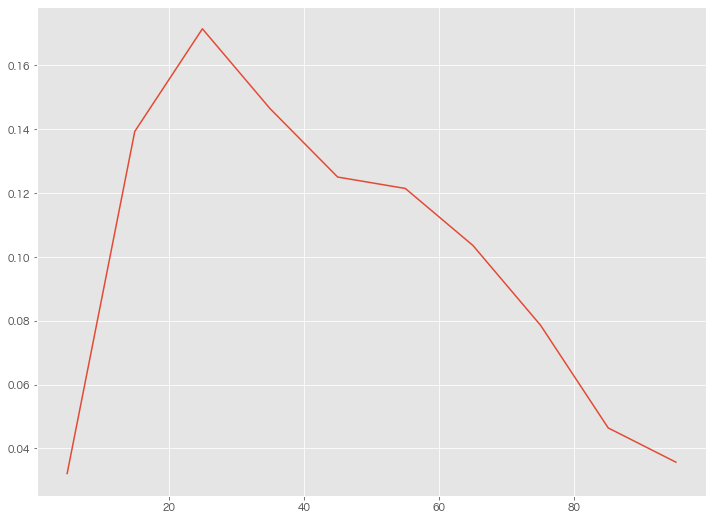

In [41]:
plt.plot(class_value, rel_freq_1)

In [23]:
q1 = hoge["battery"].quantile(0.25)
q3 = hoge["battery"].quantile(0.75)
iqr = q3 - q1

In [24]:
limit_low = q1 - iqr * 1.5
limit_high = q3 + iqr * 1.5
print("下限は%.1fです" % limit_low)
print("上限は%.1f" % limit_high)

下限は-27.1です
上限は113.9


In [26]:
q3

61.0

In [28]:
baa = hoge.query("@q1 < battery < @q3")

In [42]:
bins = np.linspace(0, 100, 11)
freq_2 = baa["battery"].value_counts(bins=bins, sort=False)
rel_freq_2 = freq_2 / baa["battery"].count()
class_value = (bins[:-1] + bins[1:]) / 2

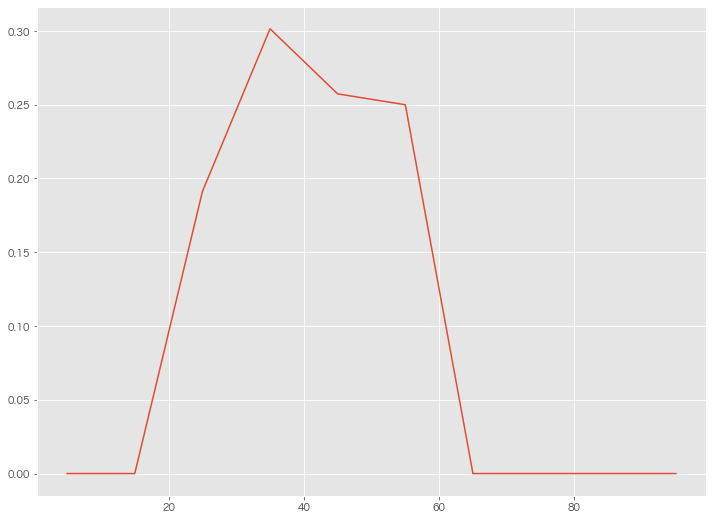

In [43]:
plt.plot(class_value, rel_freq_2)

In [30]:
len(hoge), len(baa)

(280, 136)

In [31]:
clf = LocalOutlierFactor(n_neighbors=3)

In [32]:
foo = np.array(hoge)
foo = foo.reshape(len(foo), 1)
pred = clf.fit_predict(foo)
foo = foo[np.where(pred > 0)]
foo = pd.DataFrame(foo, columns=["battery"])

In [44]:
bins = np.linspace(0, 100, 11)
freq_3 = foo["battery"].value_counts(bins=bins, sort=False)
rel_freq_3 = freq_3 / foo["battery"].count()
class_value = (bins[:-1] + bins[1:]) / 2

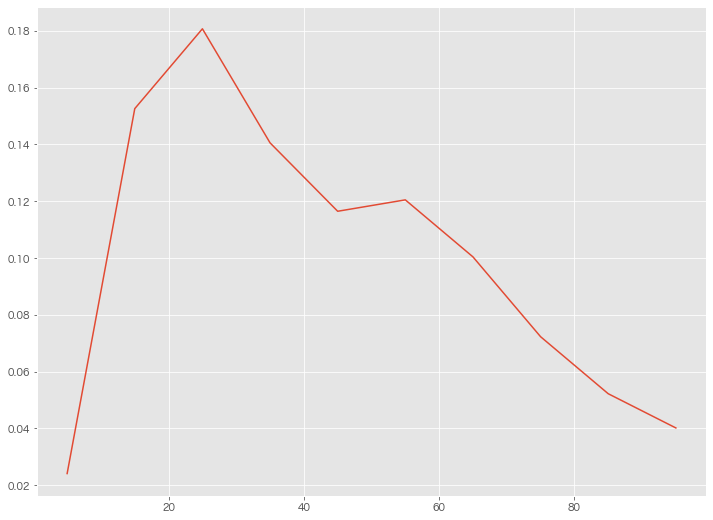

In [45]:
plt.plot(class_value, rel_freq_3)

In [35]:
len(foo)

249

In [37]:
zee = np.array(baa)
zee = zee.reshape(len(zee), 1)
pred = clf.fit_predict(zee)
zee = zee[np.where(pred > 0)]
zee = pd.DataFrame(zee, columns=["battery"])

In [46]:
bins = np.linspace(0, 100, 11)
freq_4 = zee["battery"].value_counts(bins=bins, sort=False)
rel_freq_4 = freq_4 / zee["battery"].count()
class_value = (bins[:-1] + bins[1:]) / 2

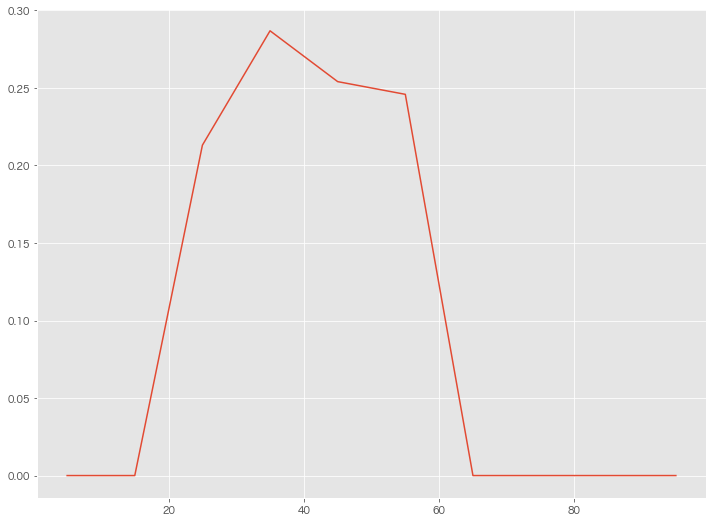

In [47]:
plt.plot(class_value, rel_freq_4)

In [39]:
len(zee)

122

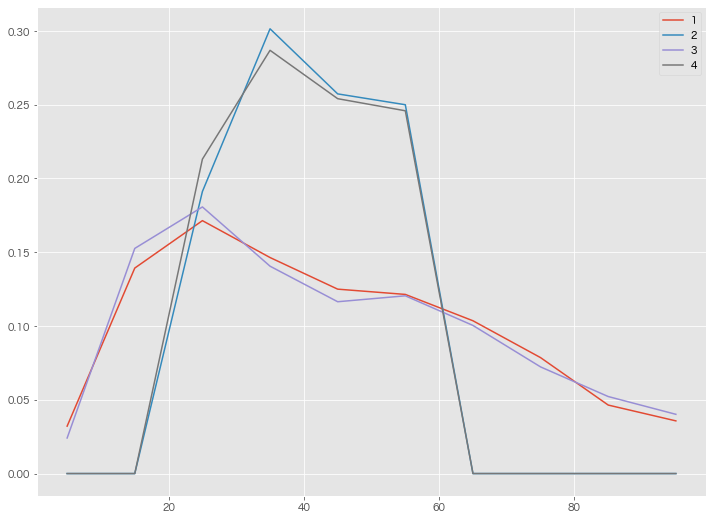

In [52]:
plt.grid
plt.plot(class_value, rel_freq_1, label="1")
plt.plot(class_value, rel_freq_2, label="2")
plt.plot(class_value, rel_freq_3, label="3")
plt.plot(class_value, rel_freq_4, label="4")
plt.legend()
plt.show()

In [54]:
print(distance.euclidean(rel_freq_1, rel_freq_3))
print(distance.euclidean(rel_freq_1, rel_freq_4))

0.02322748517840865
0.3072312690993618


0.7772277227722773


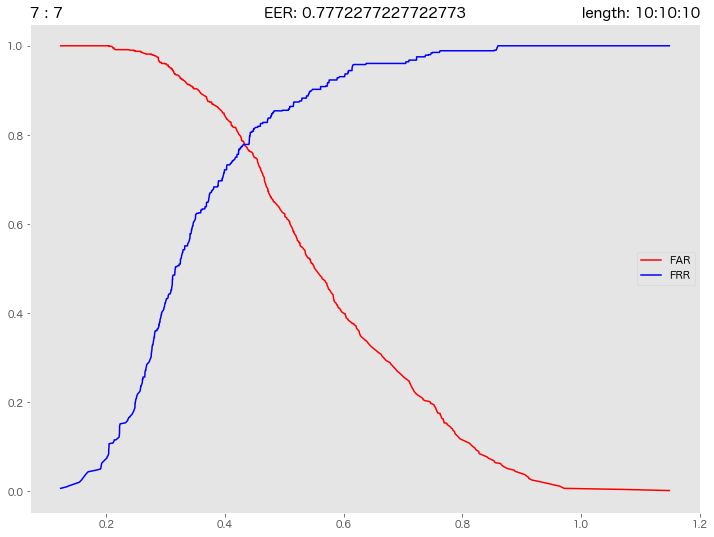

0.7821782178217822


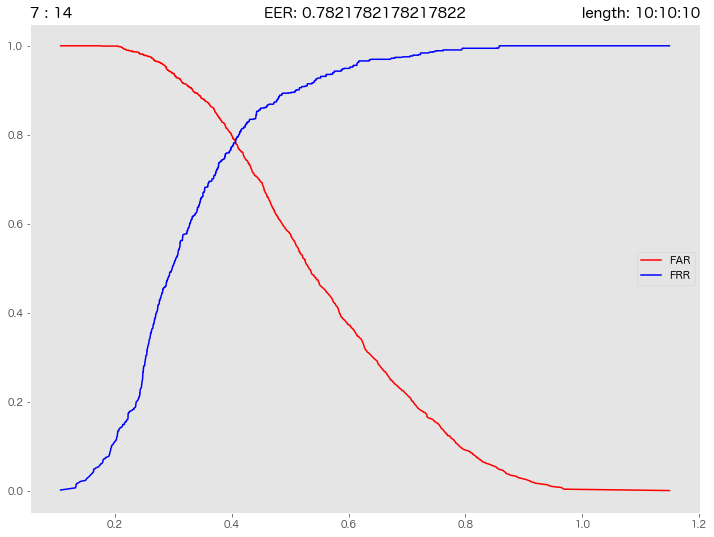

0.7986798679867987


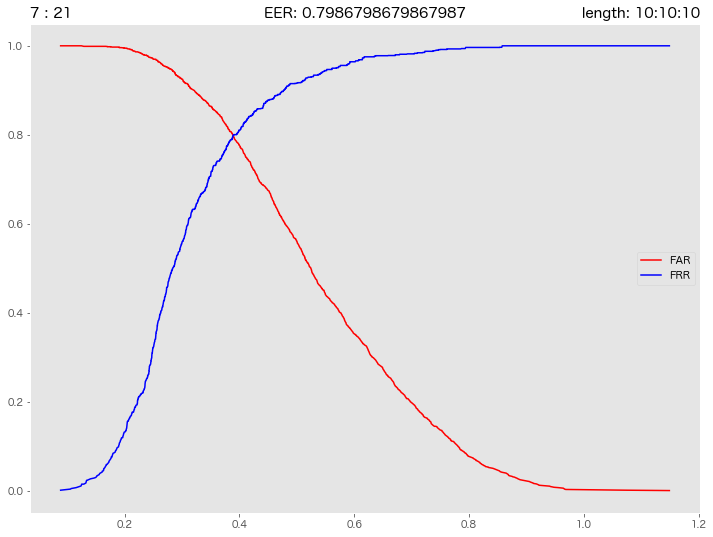

0.8001237623762376


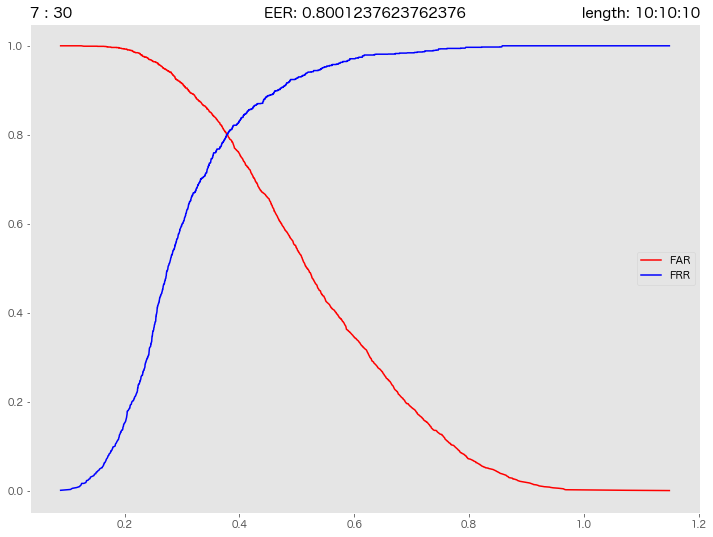

0.7945544554455446


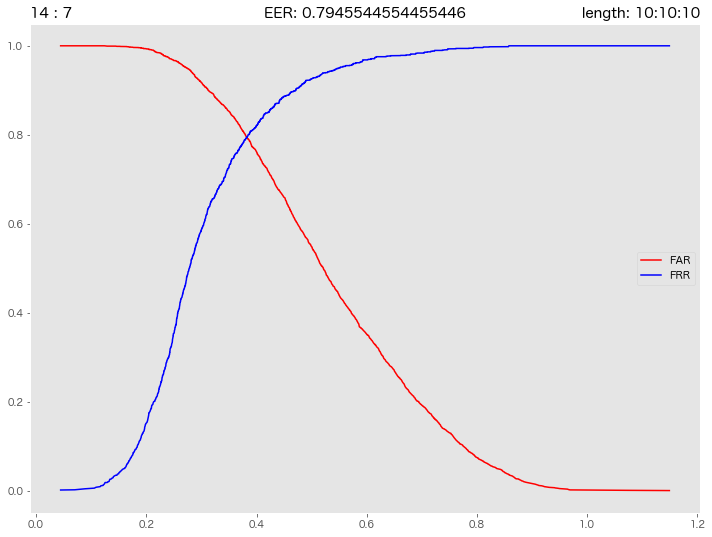

0.8013613861386139


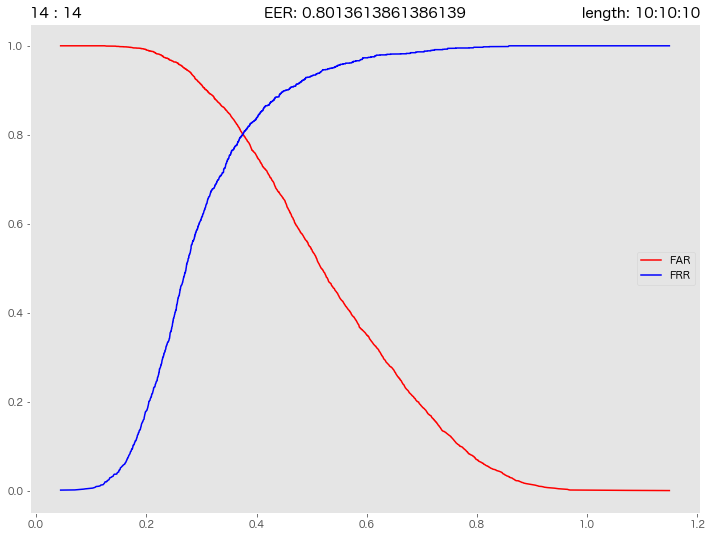

0.8033946251768034


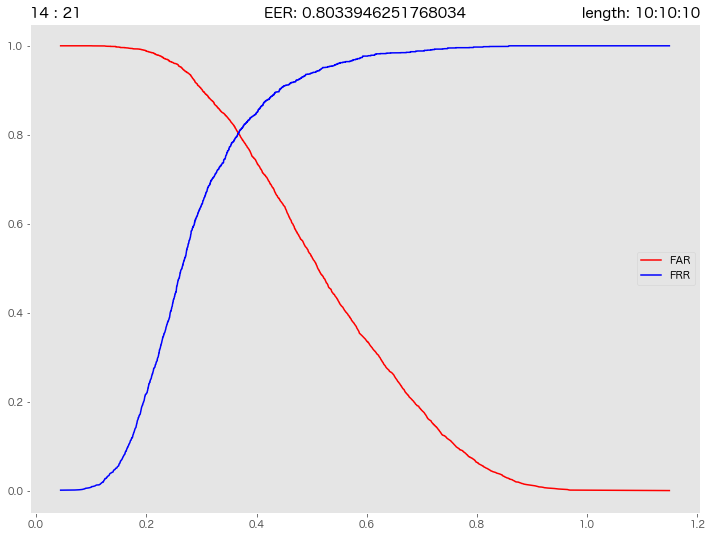

0.8064665841584159


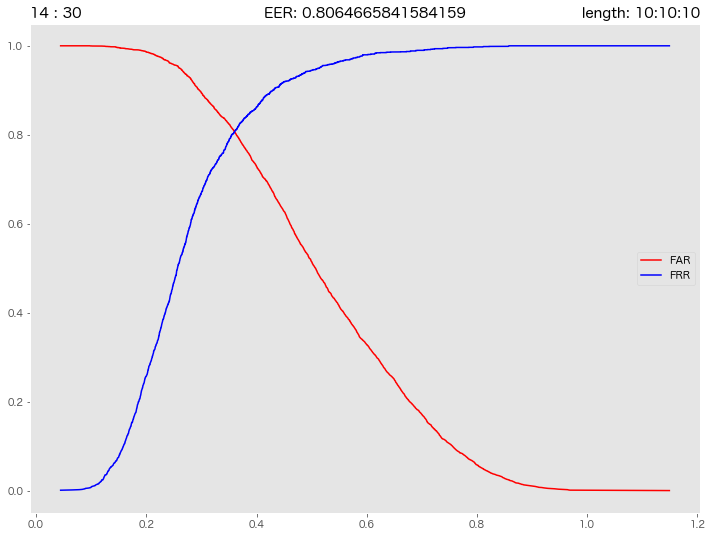

0.8065181518151815


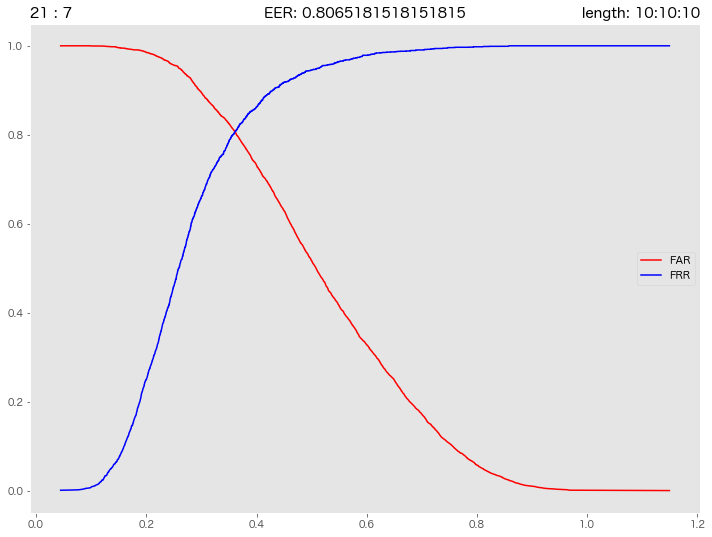

0.8092821782178218


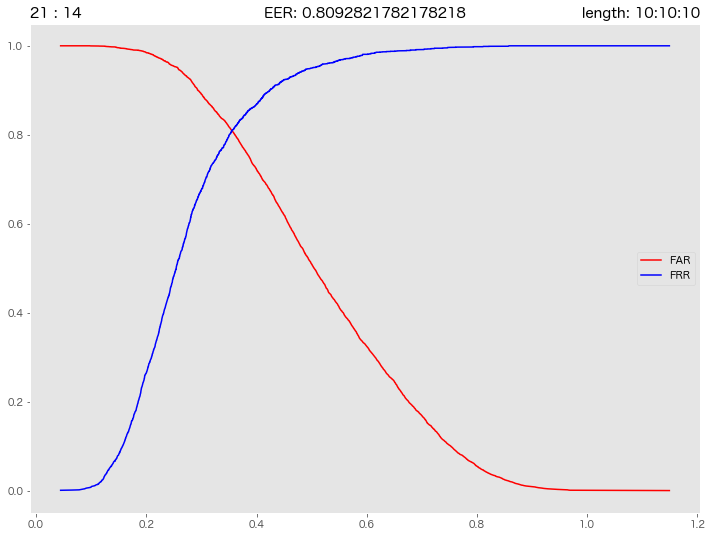

0.8107560756075608


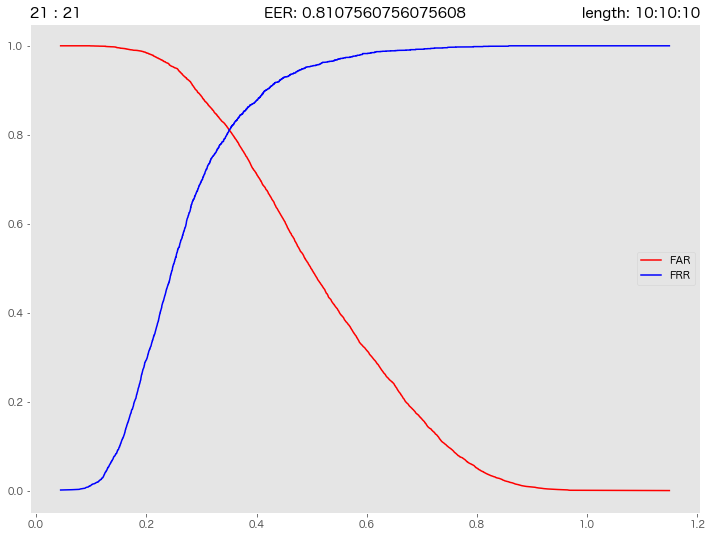

0.8127062706270627


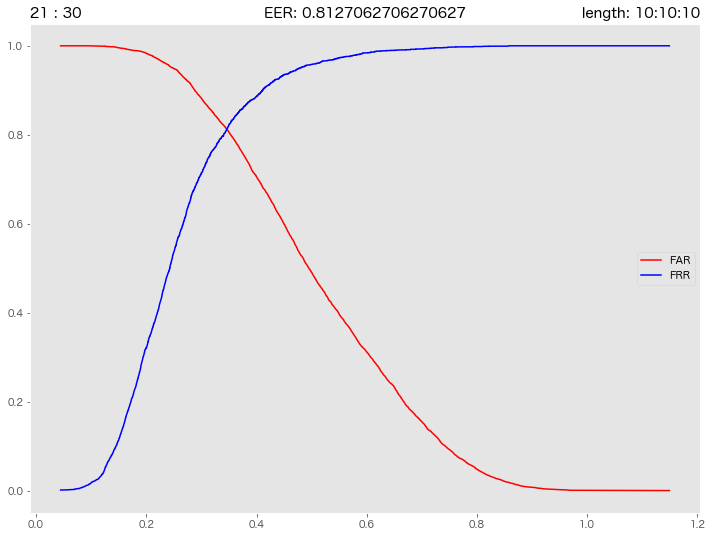

0.8116907844630616


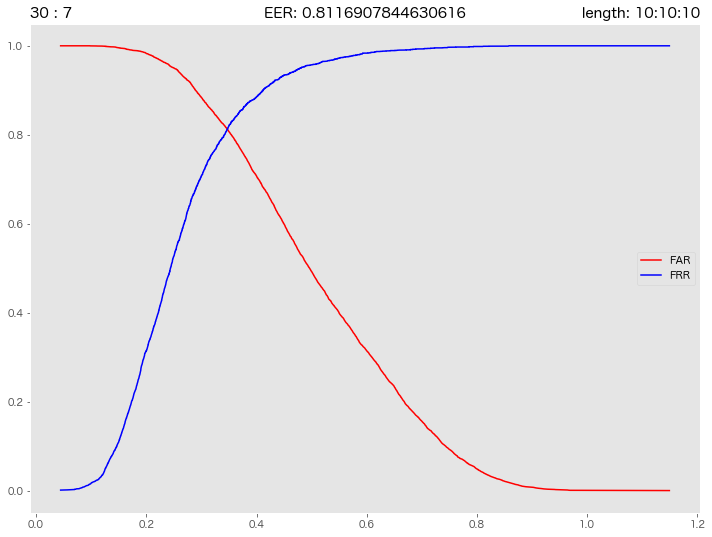

0.8126768033946252


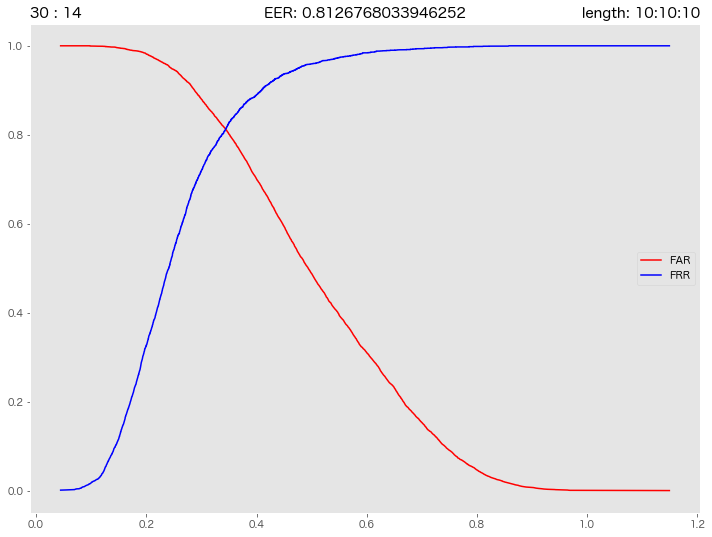

0.8127887788778878


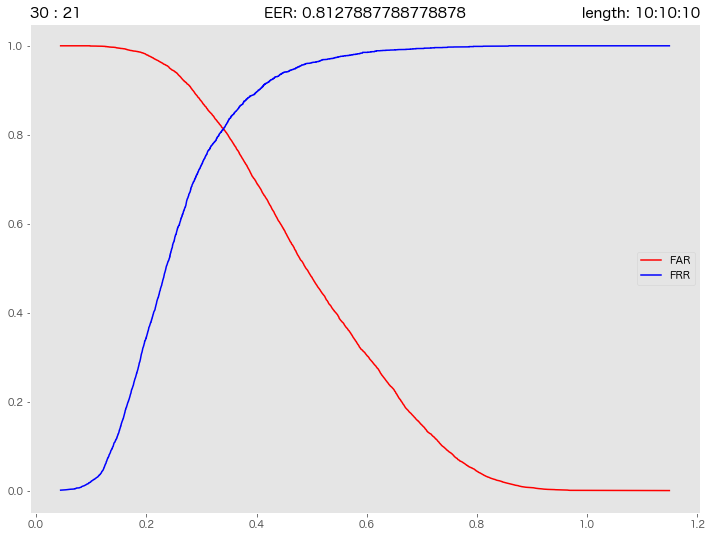

0.814743193069307


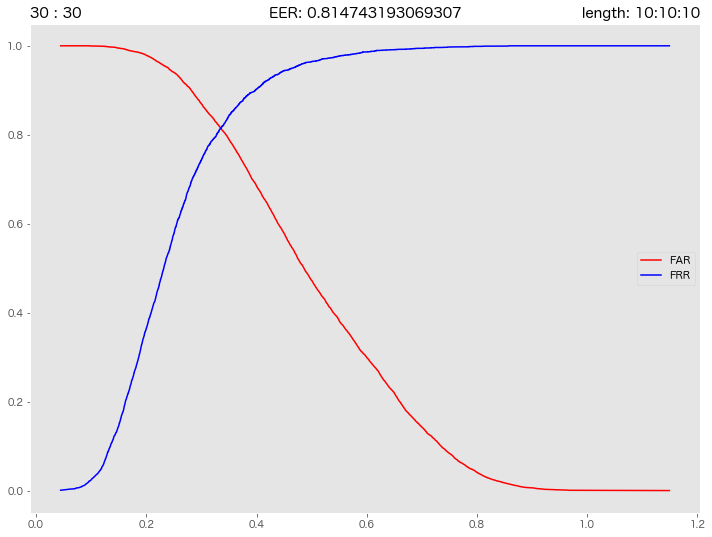

In [5]:
first_date_cand = pd.date_range("2022-01-01", "2022-02-01")
score_G = []
score_I = []

days = [7, 14, 21, 30]
data = df
clf = LocalOutlierFactor(n_neighbors=3)
bins = np.linspace(0, 100, 11)

for a in range(len(days)):
    diff_day_1 = days[a]
    for b in range(len(days)):
        diff_day_2 = days[b]
        for h in range(len(users)):
            user = users[h]
            for i in range(0, 101):
                first_date = first_date_cand[
                    np.random.randint(0, len(first_date_cand), 1)
                ]
                last_date = first_date + dt.timedelta(days=diff_day_1)
                imposters = users.copy()
                imposters = imposters[~(imposters == user)]
                imposter = np.random.choice(imposters)

                t_Q = pd.DataFrame(
                    data.loc[
                        (data["User"] == user)
                        & (data["state"] == "ON")
                        & (data["date"] > first_date[0] + dt.timedelta(seconds=1))
                        & (data["date"] < last_date[0])
                    ]["battery"].copy()
                )

                freq_1 = t_Q["battery"].value_counts(bins=bins, sort=False)
                t_Q = freq_1 / t_Q["battery"].count()

                t_T = pd.DataFrame(
                    data.loc[
                        (data["User"] == user)
                        & (data["state"] == "ON")
                        & (
                            data["date"]
                            > (first_date[0] - dt.timedelta(days=diff_day_2))
                        )
                        & (data["date"] < (first_date[0]))
                    ]["battery"].copy()
                )
                freq_1 = t_T["battery"].value_counts(bins=bins, sort=False)
                t_T = freq_1 / t_T["battery"].count()

                i_Q = pd.DataFrame(
                    data.loc[
                        (data["User"] == imposter)
                        & (data["state"] == "ON")
                        & (data["date"] > first_date[0] + dt.timedelta(seconds=1))
                        & (data["date"] < last_date[0])
                    ]["battery"].copy()
                )
                freq_1 = i_Q["battery"].value_counts(bins=bins, sort=False)
                i_Q = freq_1 / i_Q["battery"].count()

                score_G.append(distance.euclidean(t_T.values, t_Q.values))
                score_I.append(distance.euclidean(t_T.values, i_Q.values))

        grand_truth = np.concatenate((np.ones(len(score_G)), np.zeros(len(score_I))))
        score = np.concatenate((score_G, score_I))
        far, tpr, threshold = metrics.roc_curve(grand_truth, score)
        auc = metrics.auc(far, tpr)
        frr = 1.0 - tpr
        eer = far[np.where((far - frr) < 0)[0][-1]]
        print(eer)

        far_kai = pd.DataFrame(far[1:-1]).copy().set_index(threshold[1:-1])
        frr_kai = pd.DataFrame(frr[1:-1]).copy().set_index(threshold[1:-1])

        fig = plt.figure()
        plt.title(f"{diff_day_1} : {diff_day_2}", loc="left")
        plt.title(f"EER: {eer}", loc="center")
        plt.title(f"length: {len(t_T)}:{len(t_Q)}:{len(i_Q)}", loc="right")

        plt.plot(far_kai, color="r", label="FAR")
        plt.plot(frr_kai, color="b", label="FRR")
        plt.legend()
        plt.grid()
        plt.show()

        fig.savefig(f"../bs_2_results/{diff_day_1}_{diff_day_2}_freq_on.png")

0.4876237623762376


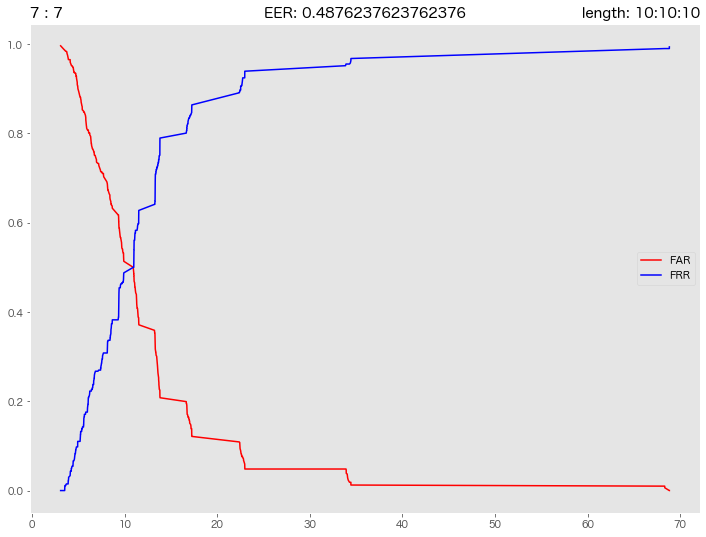

0.5068069306930693


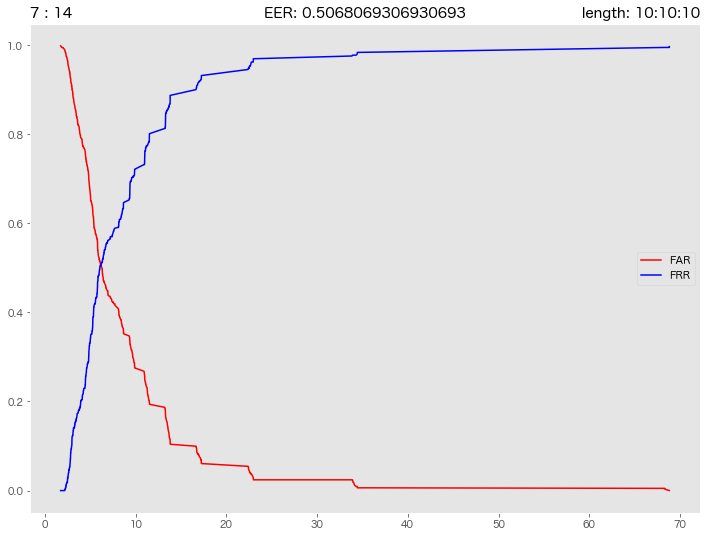

0.5024752475247525


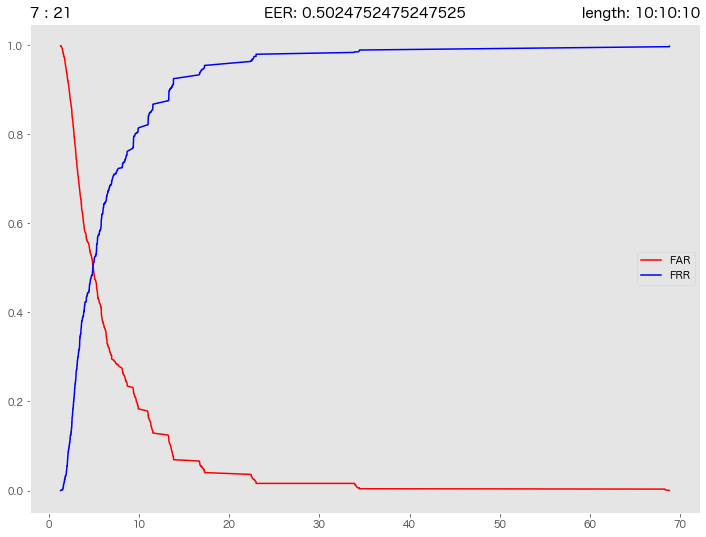

0.504950495049505


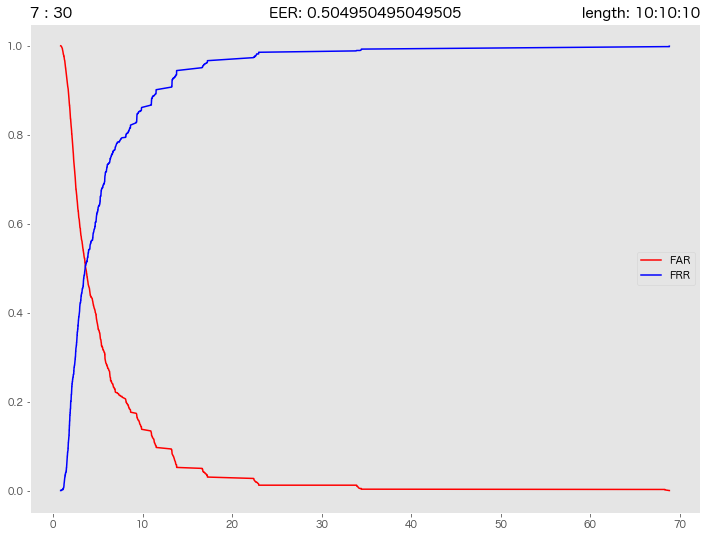

0.5017326732673267


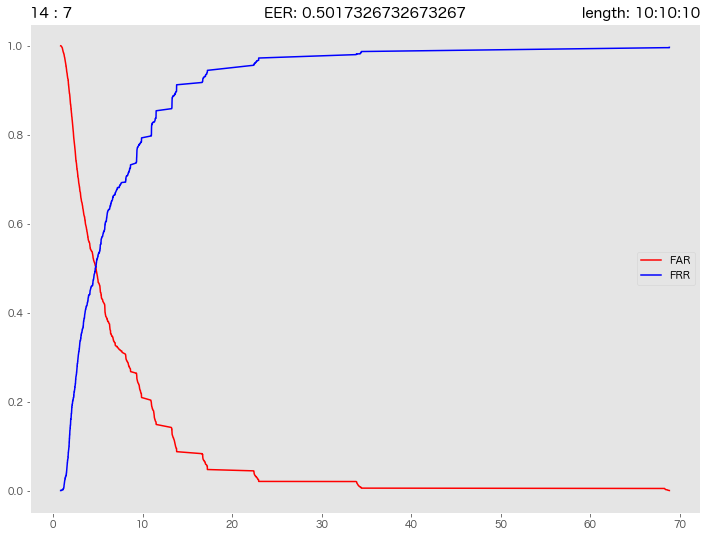

0.5016501650165016


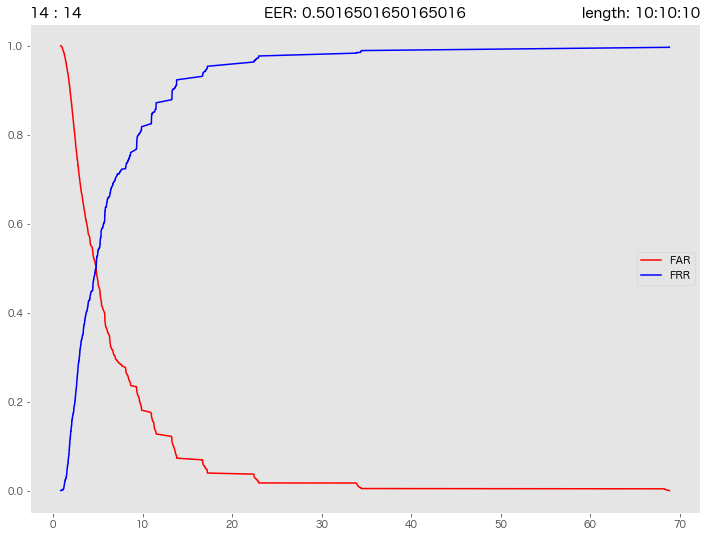

0.4991159830268741


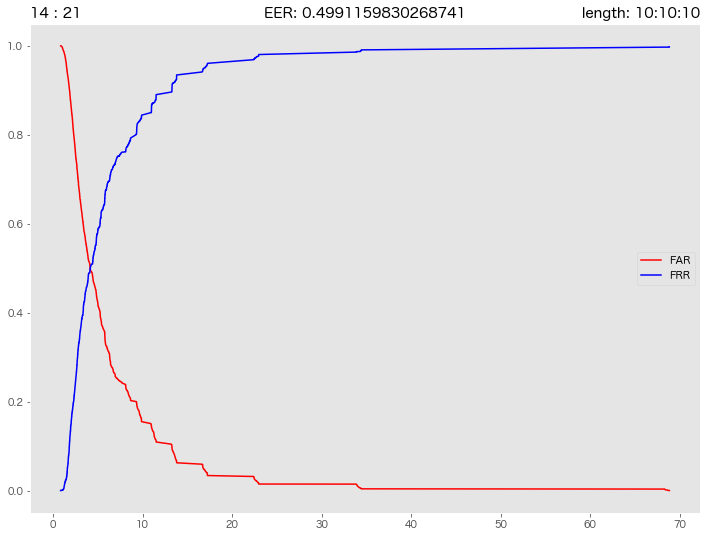

0.5021658415841584


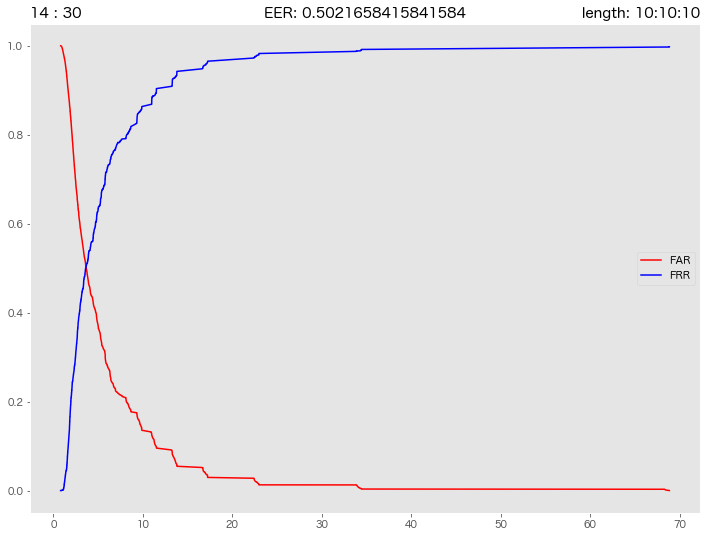

0.4976622662266227


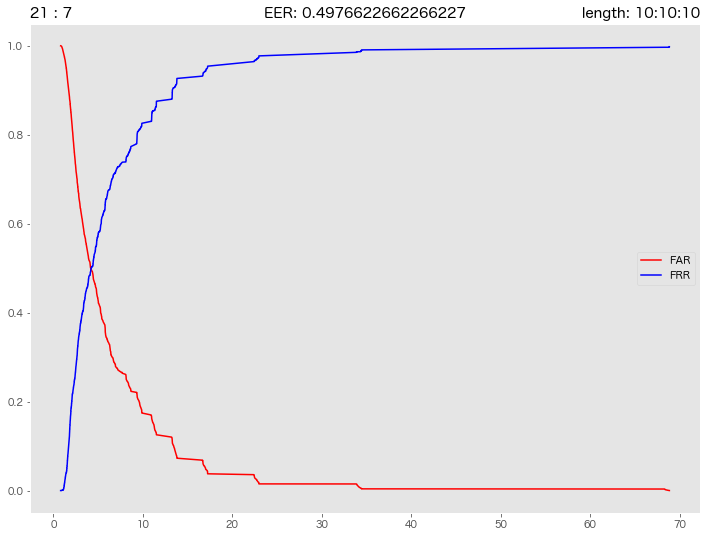

0.49554455445544554


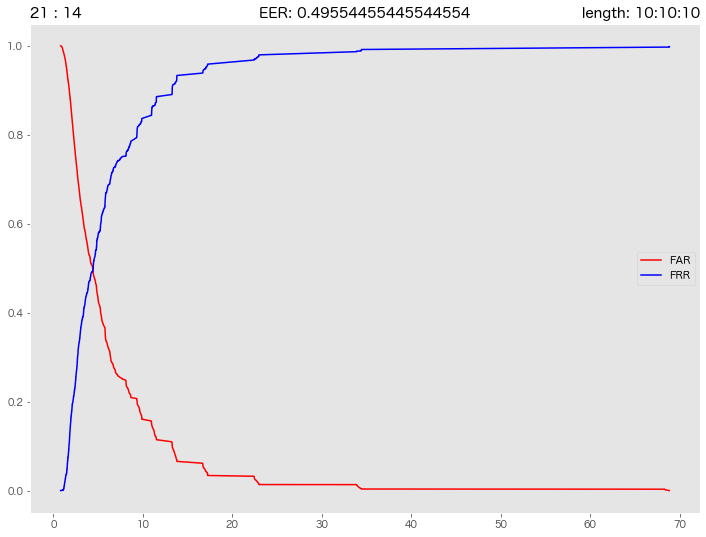

0.5007875787578758


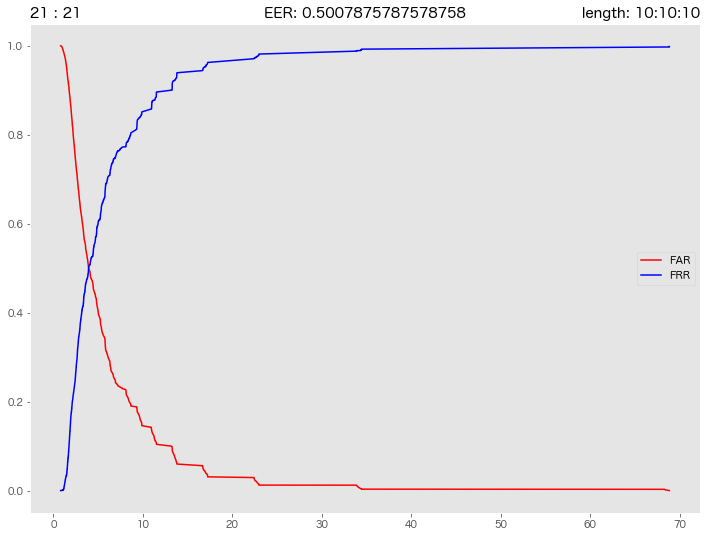

0.5015470297029703


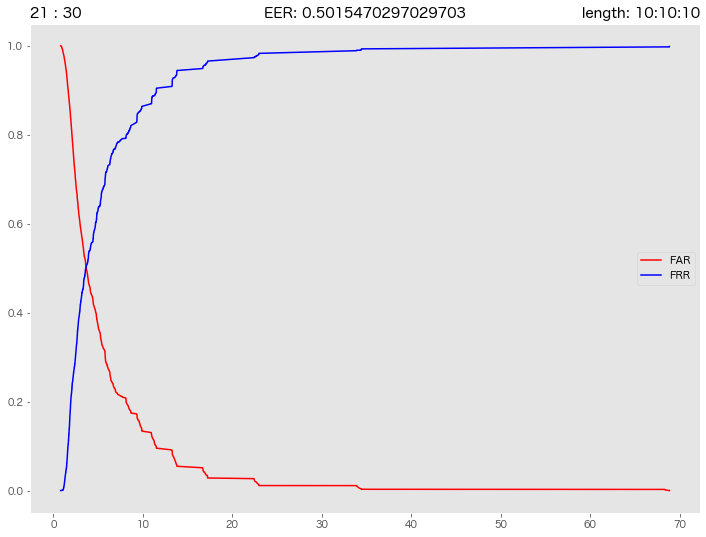

0.4993335872048743


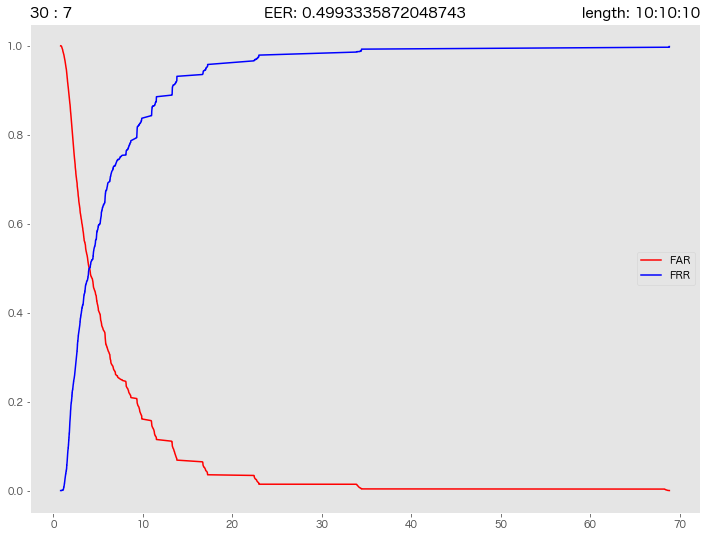

0.49814356435643564


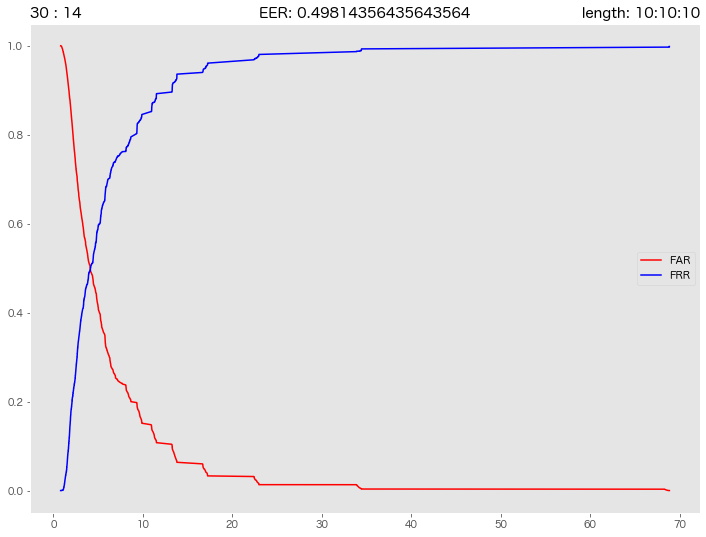

0.4976072607260726


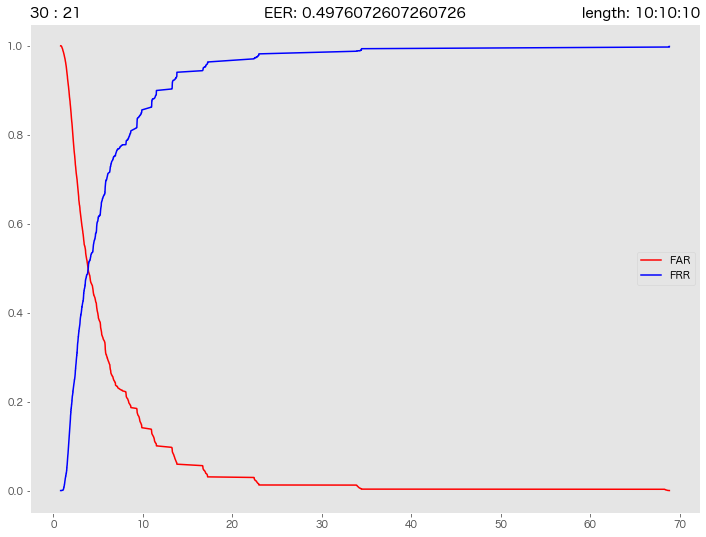

0.502243193069307


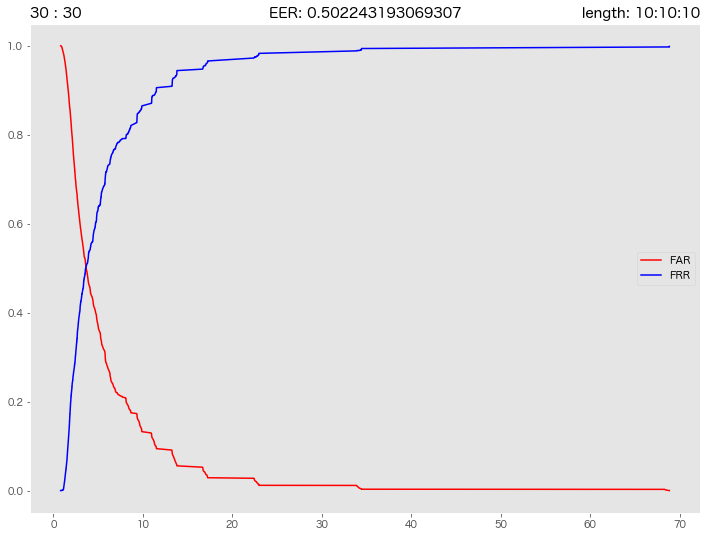

In [58]:
first_date_cand = pd.date_range("2022-01-01", "2022-02-01")
score_G = []
score_I = []
data = df
days = [7, 14, 21, 30]
clf = LocalOutlierFactor(n_neighbors=3)
bins = np.linspace(0, 100, 11)

for a in range(len(days)):
    diff_day_1 = days[a]
    for b in range(len(days)):
        diff_day_2 = days[b]
        for h in range(len(users)):
            user = users[h]
            for i in range(0, 101):
                first_date = first_date_cand[
                    np.random.randint(0, len(first_date_cand), 1)
                ]
                last_date = first_date + dt.timedelta(days=diff_day_1)
                imposters = users.copy()
                imposters = imposters[~(imposters == user)]
                imposter = np.random.choice(imposters)

                t_Q = pd.DataFrame(
                    data.loc[
                        (data["User"] == user)
                        & (data["state"] == "ON")
                        & (data["date"] > first_date[0] + dt.timedelta(seconds=1))
                        & (data["date"] < last_date[0])
                    ]["battery"].copy()
                )
                q1 = t_Q["battery"].quantile(0.25)
                q3 = t_Q["battery"].quantile(0.75)
                t_Q = t_Q.query("@q1 < battery < @q3")

                freq_1 = t_Q["battery"].value_counts(bins=bins, sort=False)
                t_Q = freq_1 / t_Q["battery"].count()

                t_T = pd.DataFrame(
                    data.loc[
                        (data["User"] == user)
                        & (data["state"] == "ON")
                        & (
                            data["date"]
                            > (first_date[0] - dt.timedelta(days=diff_day_2))
                        )
                        & (data["date"] < (first_date[0]))
                    ]["battery"].copy()
                )
                q1 = t_T["battery"].quantile(0.25)
                q3 = t_T["battery"].quantile(0.75)
                t_T = t_T.query("@q1 < battery < @q3")
                freq_1 = t_T["battery"].value_counts(bins=bins, sort=False)
                t_T = freq_2 / t_T["battery"].count()

                i_Q = pd.DataFrame(
                    data.loc[
                        (data["User"] == imposter)
                        & (data["state"] == "ON")
                        & (data["date"] > first_date[0] + dt.timedelta(seconds=1))
                        & (data["date"] < last_date[0])
                    ]["battery"].copy()
                )
                q1 = i_Q["battery"].quantile(0.25)
                q3 = i_Q["battery"].quantile(0.75)
                i_Q = i_Q.query("@q1 < battery < @q3")
                freq_1 = i_Q["battery"].value_counts(bins=bins, sort=False)
                i_Q = freq_1 / i_Q["battery"].count()

                score_G.append(distance.euclidean(t_T, t_Q))
                score_I.append(distance.euclidean(t_T, i_Q))

        grand_truth = np.concatenate((np.ones(len(score_G)), np.zeros(len(score_I))))
        score = np.concatenate((score_G, score_I))
        far, tpr, threshold = metrics.roc_curve(grand_truth, score)
        auc = metrics.auc(far, tpr)
        frr = 1.0 - tpr
        eer = far[np.where((far - frr) < 0)[0][-1]]
        print(eer)

        far_kai = pd.DataFrame(far[1:-1]).copy().set_index(threshold[1:-1])
        frr_kai = pd.DataFrame(frr[1:-1]).copy().set_index(threshold[1:-1])

        fig = plt.figure()
        plt.title(f"{diff_day_1} : {diff_day_2}", loc="left")
        plt.title(f"EER: {eer}", loc="center")
        plt.title(f"length: {len(t_T)}:{len(t_Q)}:{len(i_Q)}", loc="right")

        plt.plot(far_kai, color="r", label="FAR")
        plt.plot(frr_kai, color="b", label="FRR")
        plt.legend()
        plt.grid()
        plt.show()

        fig.savefig(f"../bs_2_results/{diff_day_1}_{diff_day_2}_freq_q_on.png")

0.5037128712871287


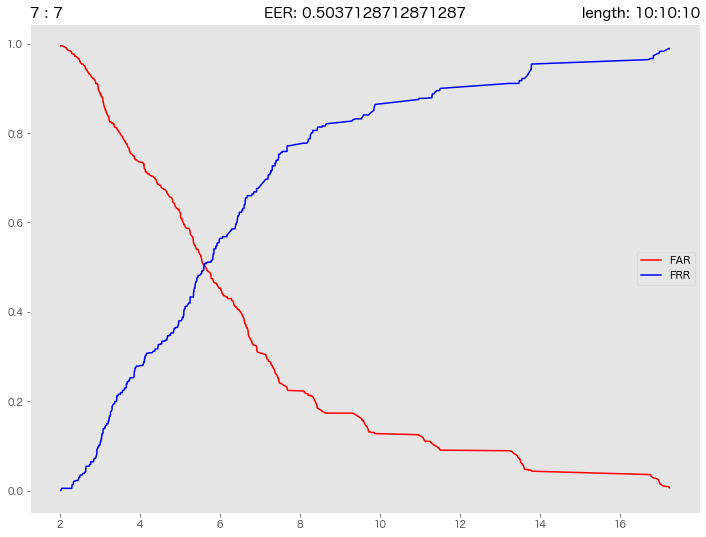

0.4969059405940594


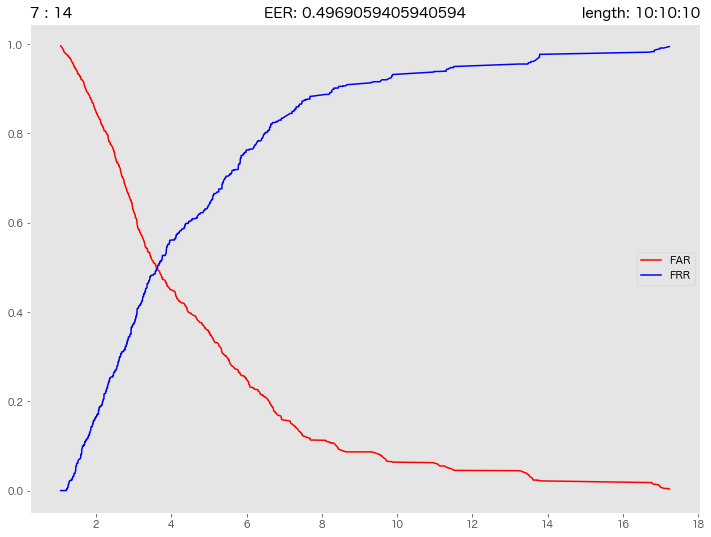

0.4975247524752475


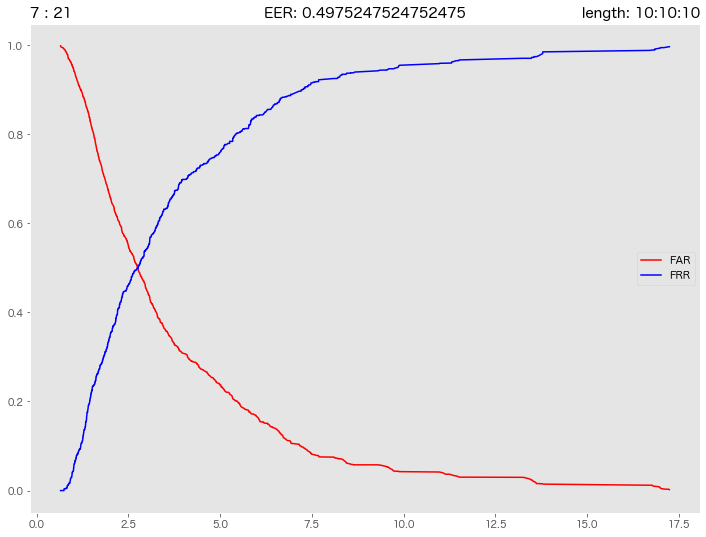

0.4978341584158416


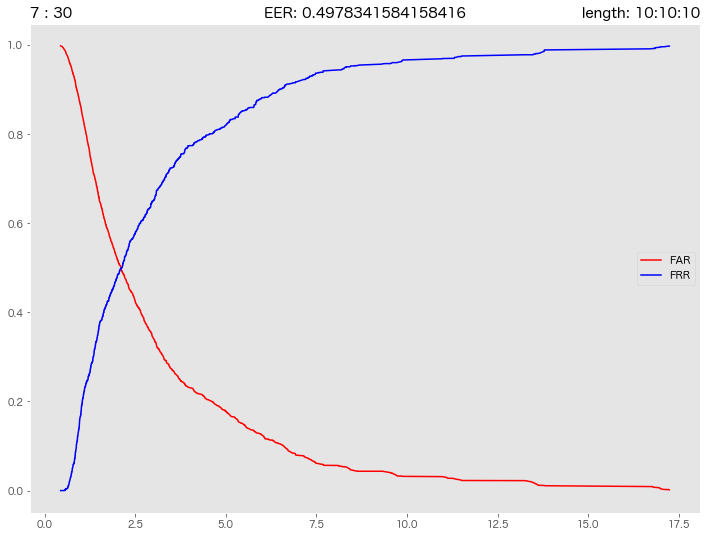

0.49826732673267327


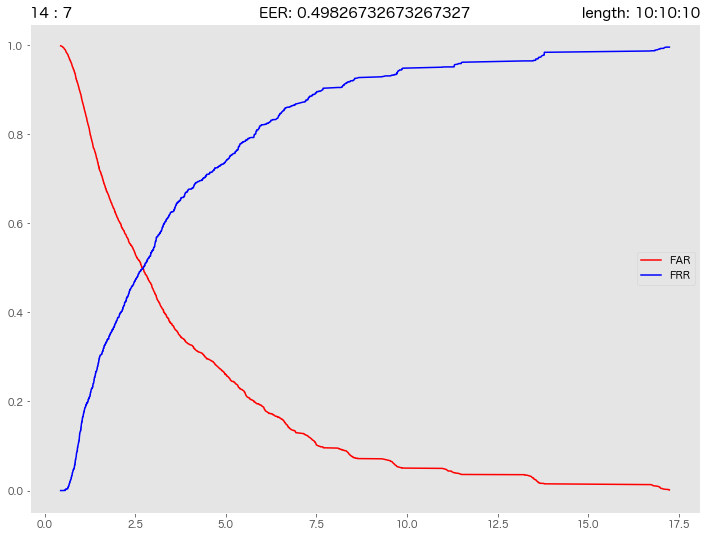

0.5028877887788779


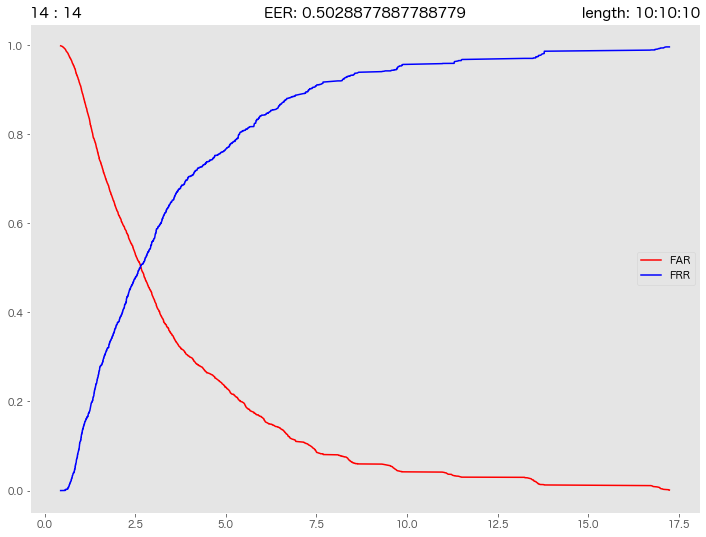

0.5053041018387553


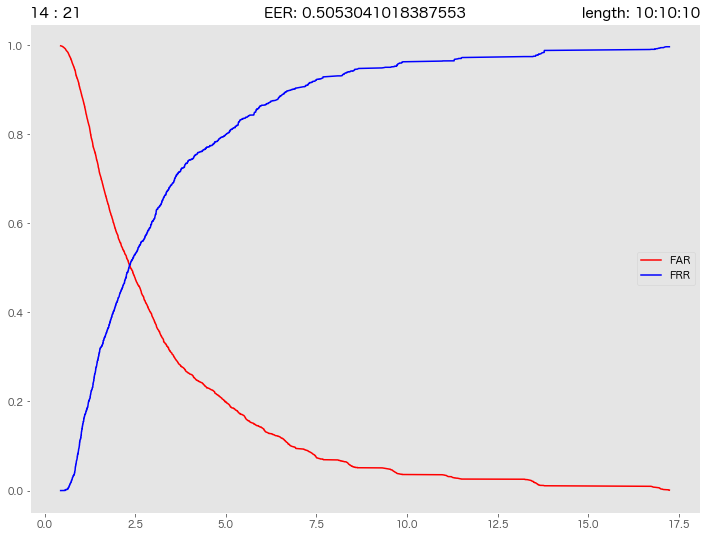

0.49845297029702973


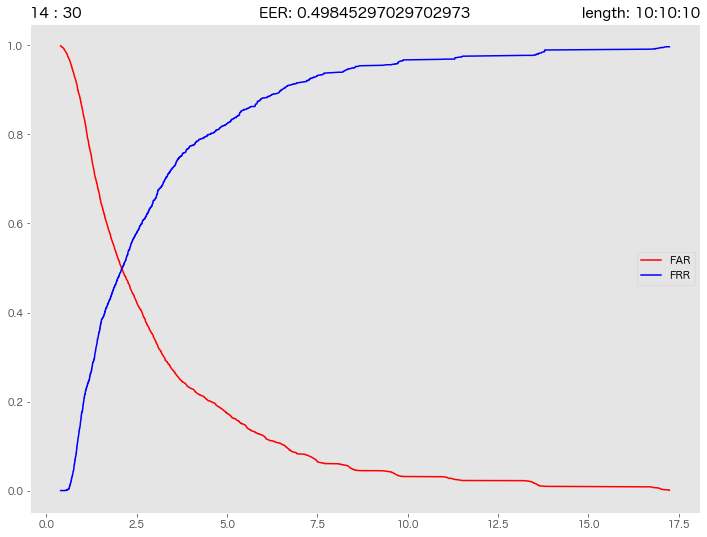

0.5019251925192519


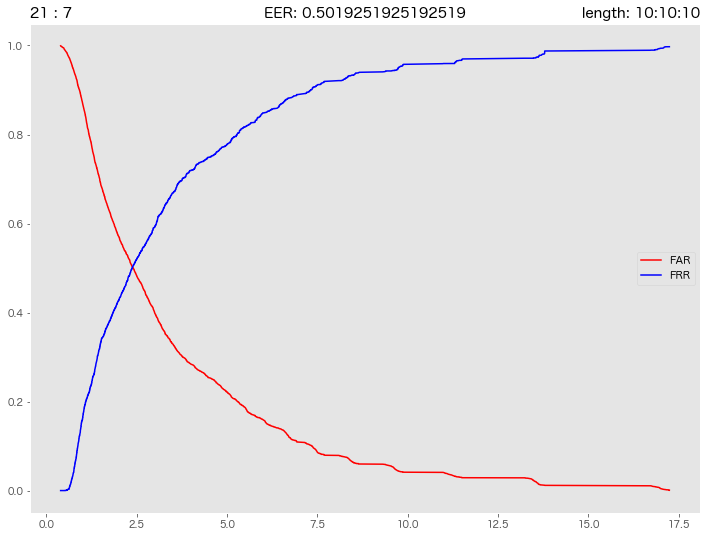

0.504579207920792


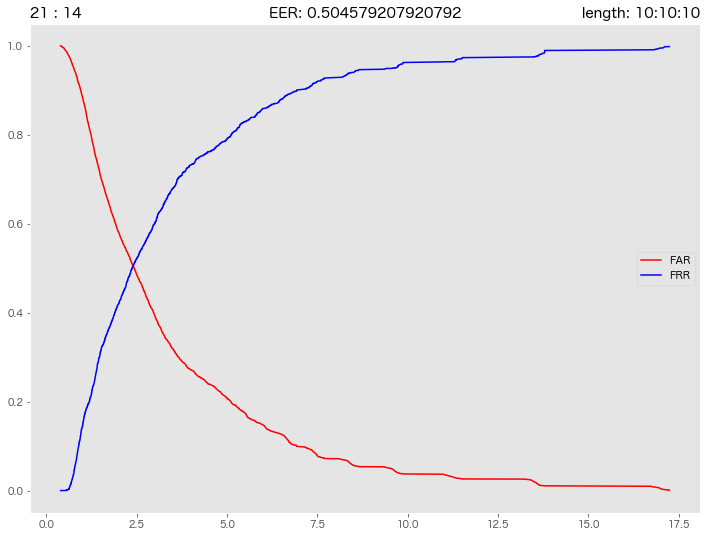

0.5025877587758776


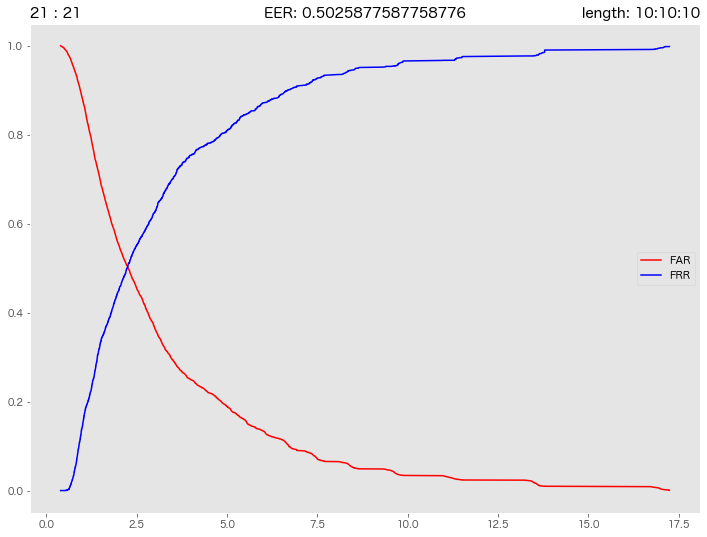

0.49896864686468645


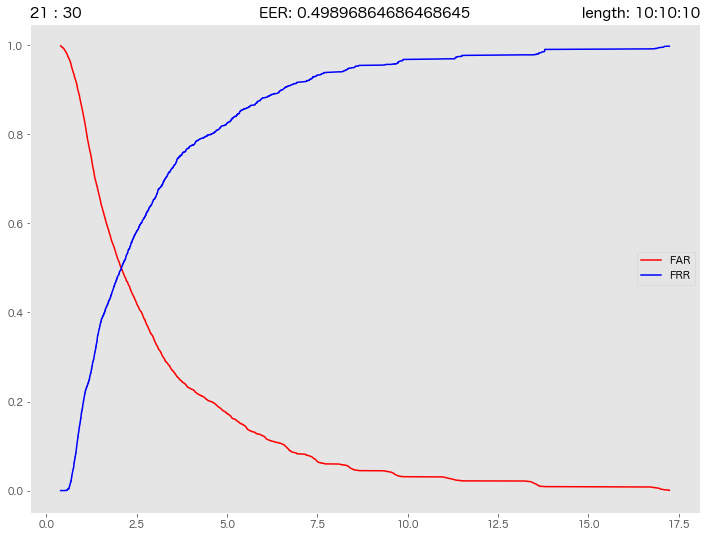

0.5005712109672505


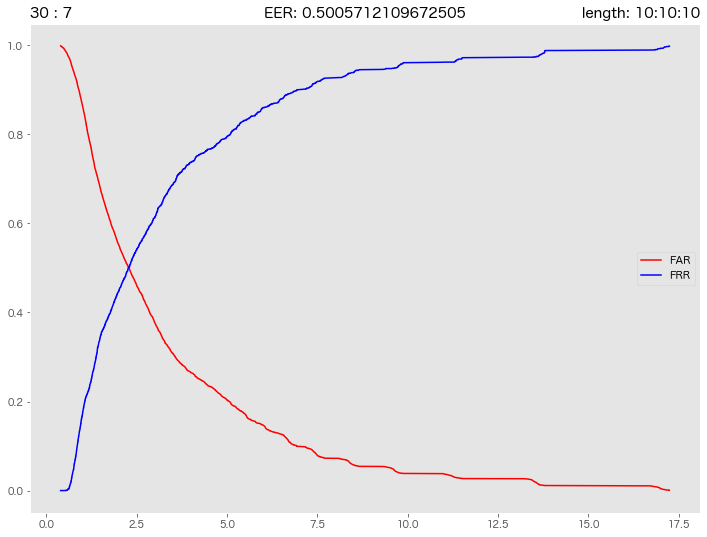

0.5027404526166902


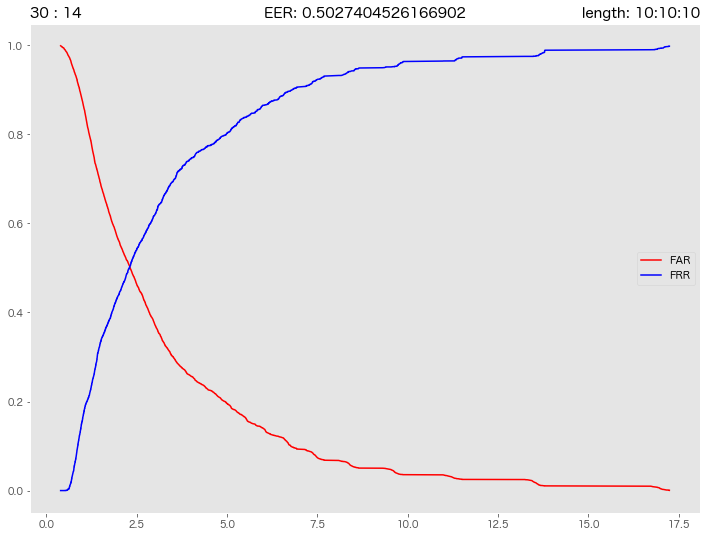

0.5006600660066006


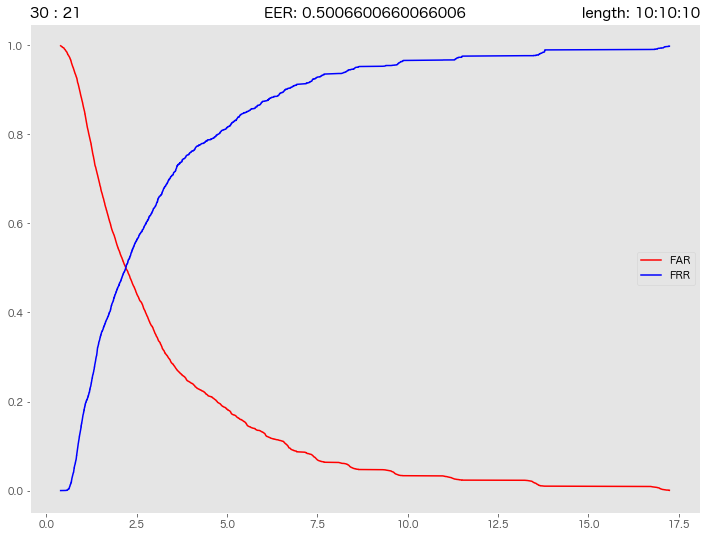

0.49914913366336633


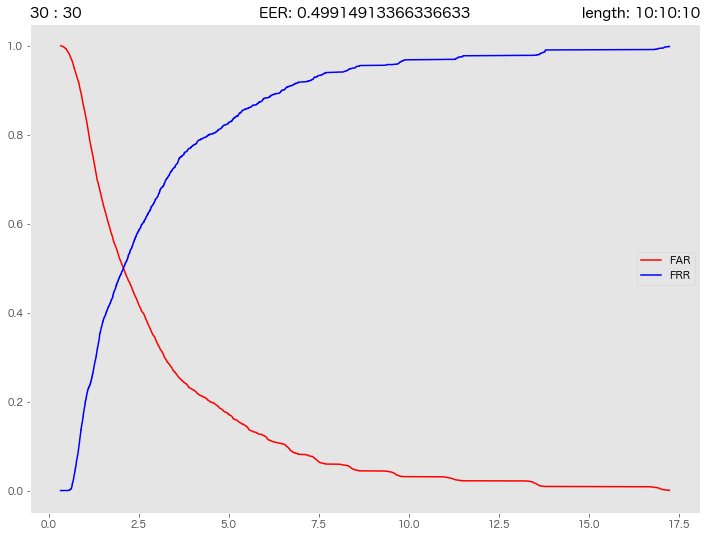

In [59]:
first_date_cand = pd.date_range("2022-01-01", "2022-02-01")
score_G = []
score_I = []
data = df
days = [7, 14, 21, 30]
clf = LocalOutlierFactor(n_neighbors=3)
bins = np.linspace(0, 100, 11)

for a in range(len(days)):
    diff_day_1 = days[a]
    for b in range(len(days)):
        diff_day_2 = days[b]
        for h in range(len(users)):
            user = users[h]
            for i in range(0, 101):
                first_date = first_date_cand[
                    np.random.randint(0, len(first_date_cand), 1)
                ]
                last_date = first_date + dt.timedelta(days=diff_day_1)
                imposters = users.copy()
                imposters = imposters[~(imposters == user)]
                imposter = np.random.choice(imposters)

                t_Q = pd.DataFrame(
                    data.loc[
                        (data["User"] == user)
                        & (data["state"] == "ON")
                        & (data["date"] > first_date[0] + dt.timedelta(seconds=1))
                        & (data["date"] < last_date[0])
                    ]["battery"].copy()
                )
                t_Q = np.array(t_Q)
                t_Q = t_Q.reshape(len(t_Q), 1)
                pred = clf.fit_predict(t_Q)
                t_Q = t_Q[np.where(pred > 0)]
                t_Q = pd.DataFrame(t_Q, columns=["battery"])

                freq_1 = t_Q["battery"].value_counts(bins=bins, sort=False)
                t_Q = freq_1 / t_Q["battery"].count()

                t_T = pd.DataFrame(
                    data.loc[
                        (data["User"] == user)
                        & (data["state"] == "ON")
                        & (
                            data["date"]
                            > (first_date[0] - dt.timedelta(days=diff_day_2))
                        )
                        & (data["date"] < (first_date[0]))
                    ]["battery"].copy()
                )
                t_T = np.array(t_T)
                t_T = t_T.reshape(len(t_T), 1)
                pred = clf.fit_predict(t_T)
                t_T = t_T[np.where(pred > 0)]
                t_T = pd.DataFrame(t_T, columns=["battery"])

                freq_1 = t_T["battery"].value_counts(bins=bins, sort=False)
                t_T = freq_2 / t_T["battery"].count()

                i_Q = pd.DataFrame(
                    data.loc[
                        (data["User"] == imposter)
                        & (data["state"] == "ON")
                        & (data["date"] > first_date[0] + dt.timedelta(seconds=1))
                        & (data["date"] < last_date[0])
                    ]["battery"].copy()
                )
                i_Q = np.array(i_Q)
                i_Q = i_Q.reshape(len(i_Q), 1)
                pred = clf.fit_predict(i_Q)
                i_Q = i_Q[np.where(pred > 0)]
                i_Q = pd.DataFrame(i_Q, columns=["battery"])
                freq_1 = i_Q["battery"].value_counts(bins=bins, sort=False)
                i_Q = freq_1 / i_Q["battery"].count()

                score_G.append(distance.euclidean(t_T, t_Q))
                score_I.append(distance.euclidean(t_T, i_Q))

        grand_truth = np.concatenate((np.ones(len(score_G)), np.zeros(len(score_I))))
        score = np.concatenate((score_G, score_I))
        far, tpr, threshold = metrics.roc_curve(grand_truth, score)
        auc = metrics.auc(far, tpr)
        frr = 1.0 - tpr
        eer = far[np.where((far - frr) < 0)[0][-1]]
        print(eer)

        far_kai = pd.DataFrame(far[1:-1]).copy().set_index(threshold[1:-1])
        frr_kai = pd.DataFrame(frr[1:-1]).copy().set_index(threshold[1:-1])

        fig = plt.figure()
        plt.title(f"{diff_day_1} : {diff_day_2}", loc="left")
        plt.title(f"EER: {eer}", loc="center")
        plt.title(f"length: {len(t_T)}:{len(t_Q)}:{len(i_Q)}", loc="right")

        plt.plot(far_kai, color="r", label="FAR")
        plt.plot(frr_kai, color="b", label="FRR")
        plt.legend()
        plt.grid()
        plt.show()

        fig.savefig(f"../bs_2_results/{diff_day_1}_{diff_day_2}_freq_lof_on.png")

0.4956896551724138


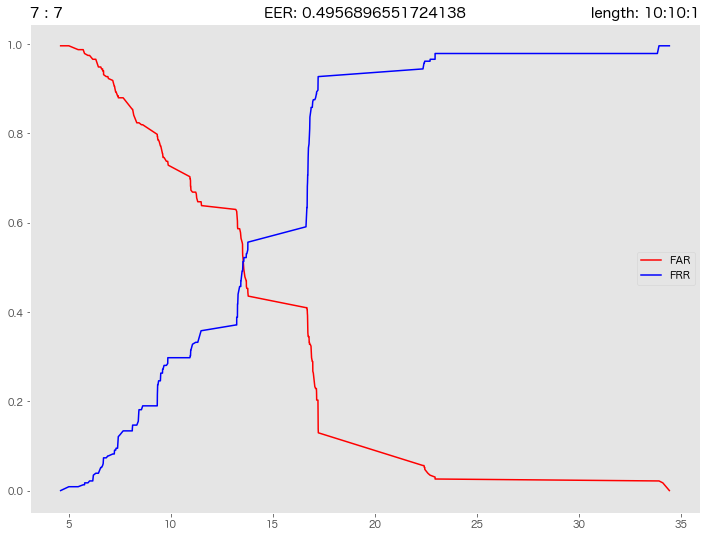

0.4929906542056075


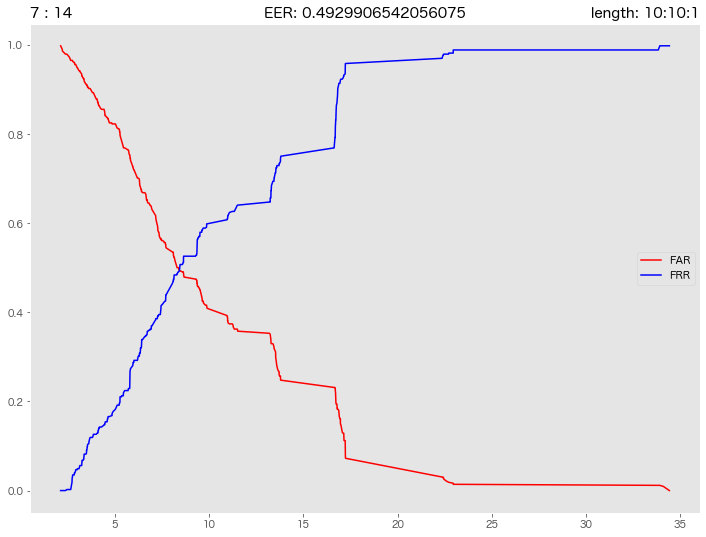

0.49693251533742333


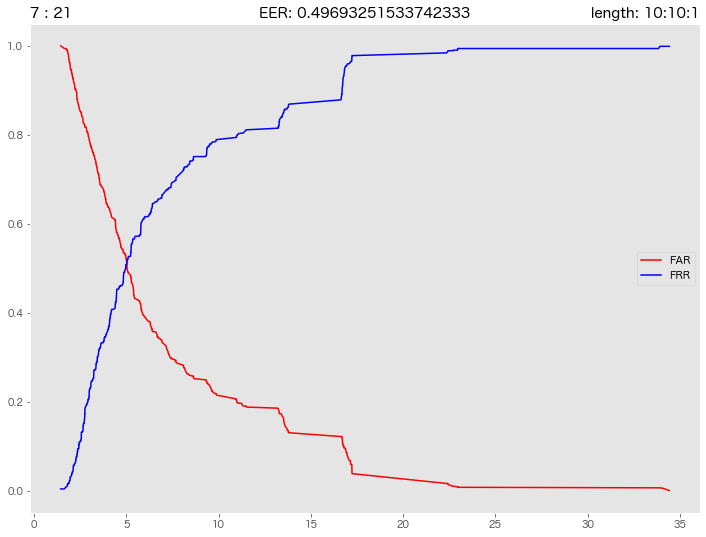

0.5089928057553957


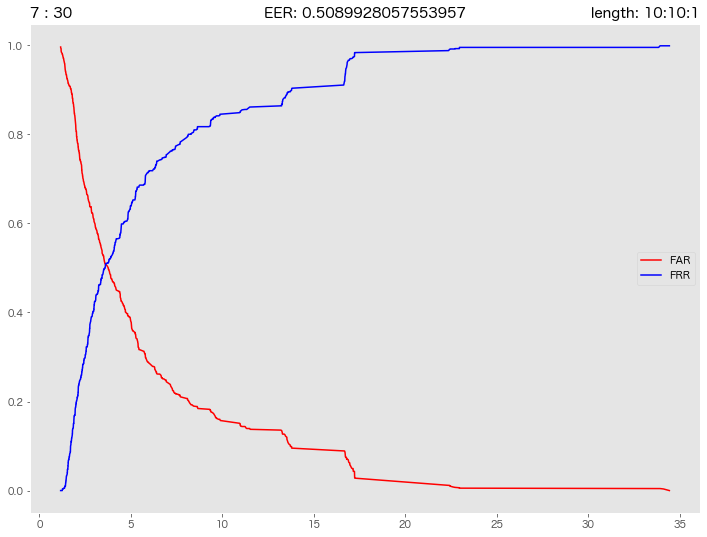

0.5008219178082192


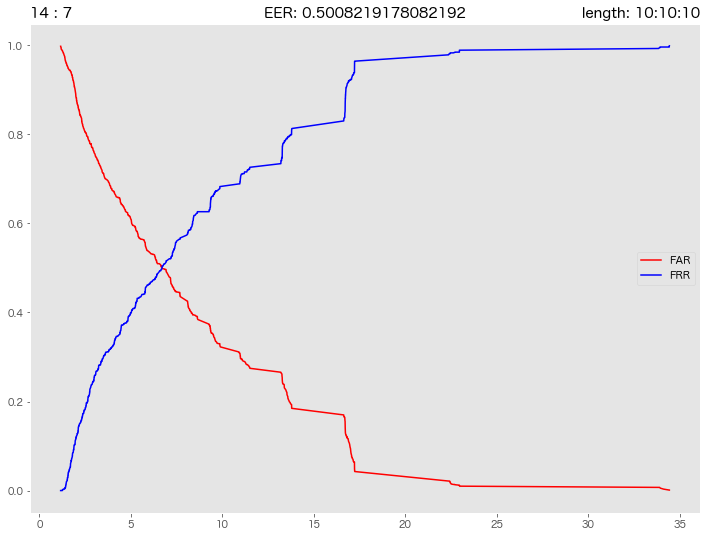

0.5024686669198632


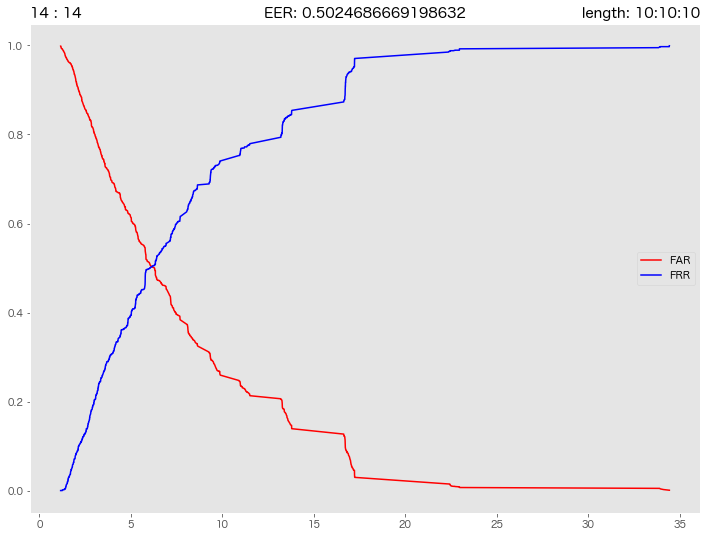

0.5033420517291485


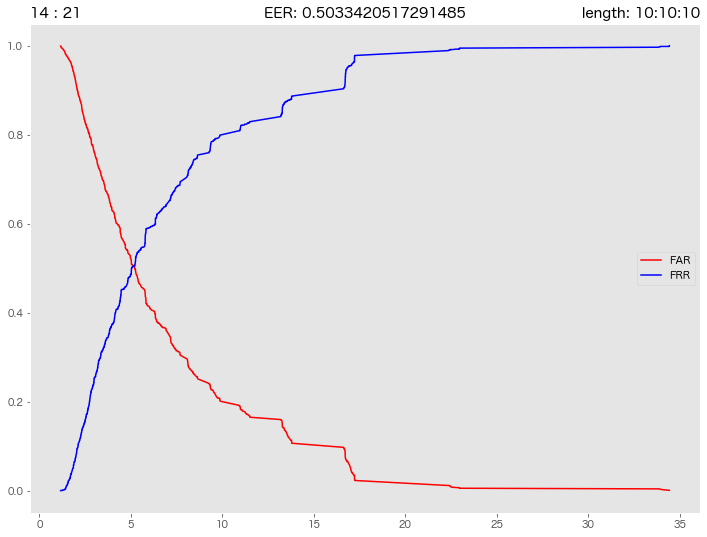

0.49964697575900213


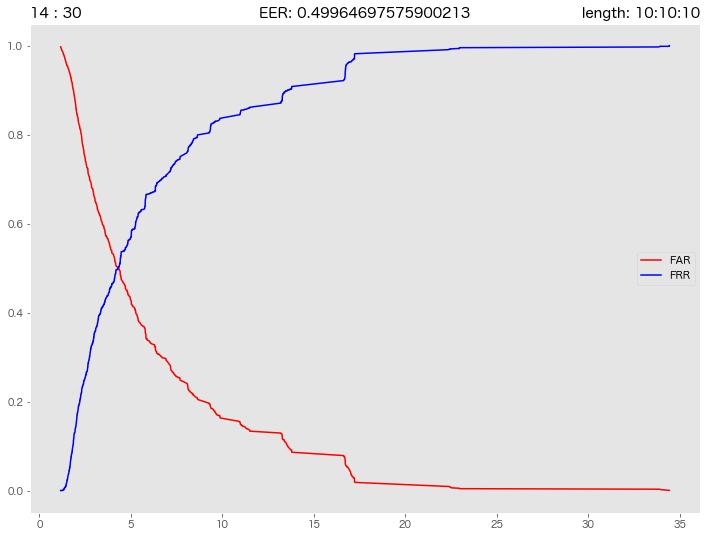

0.4951632406287787


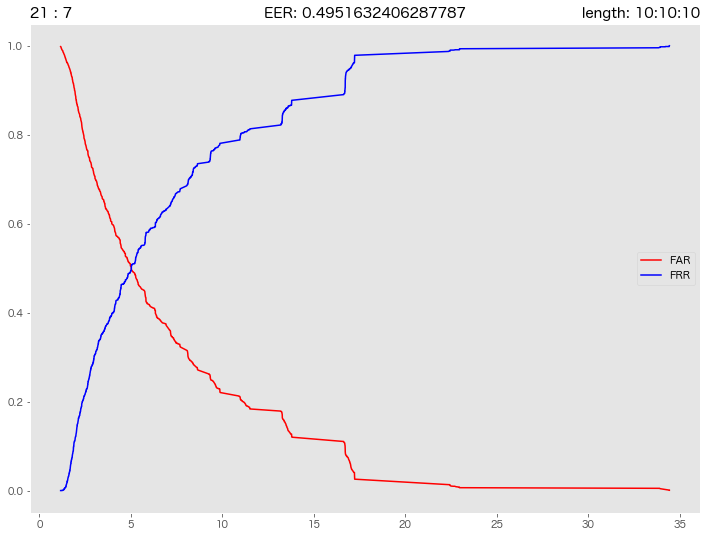

0.5005199306759098


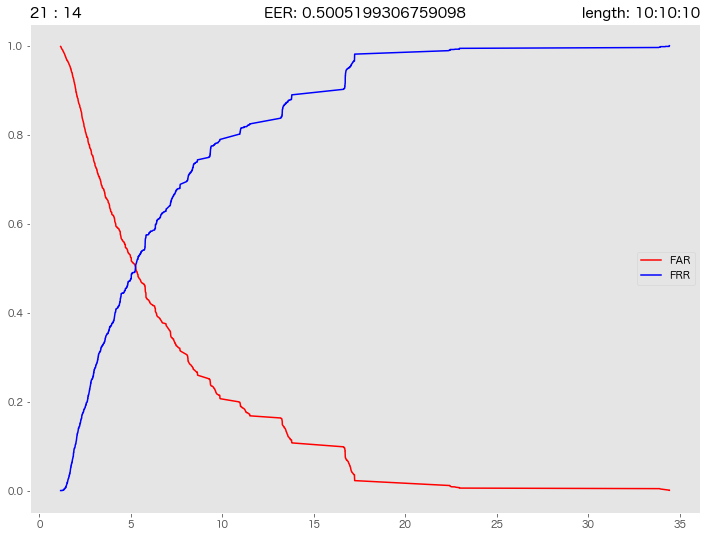

0.501824262693828


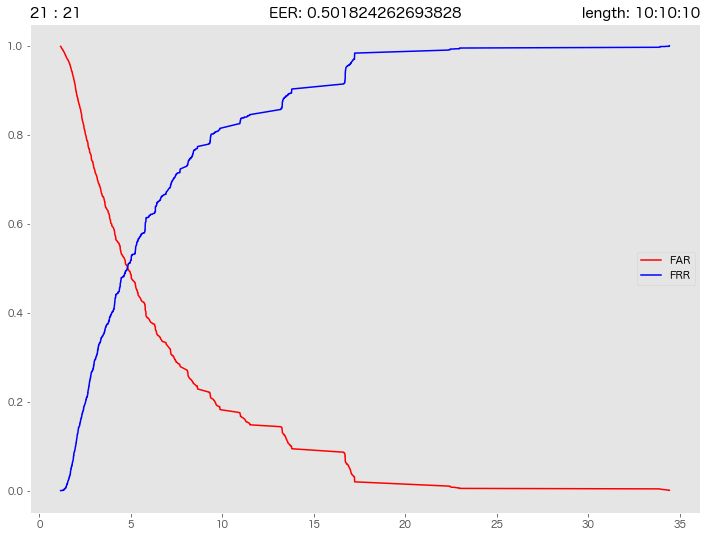

0.5002707825616031


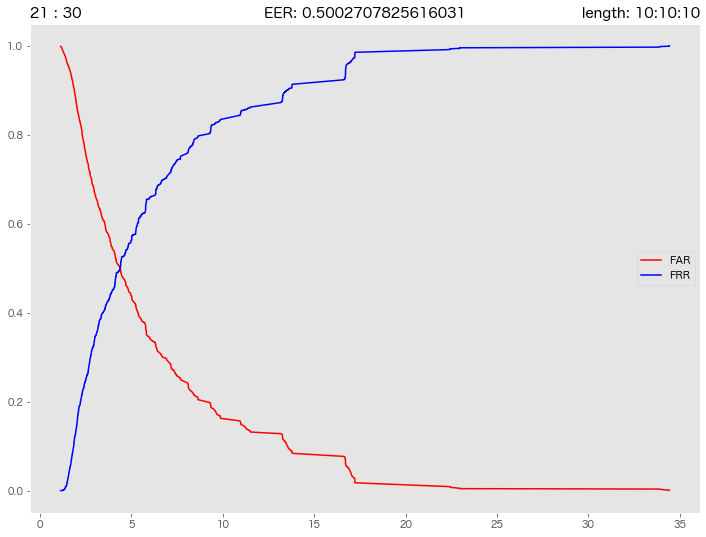

0.5000617360167922


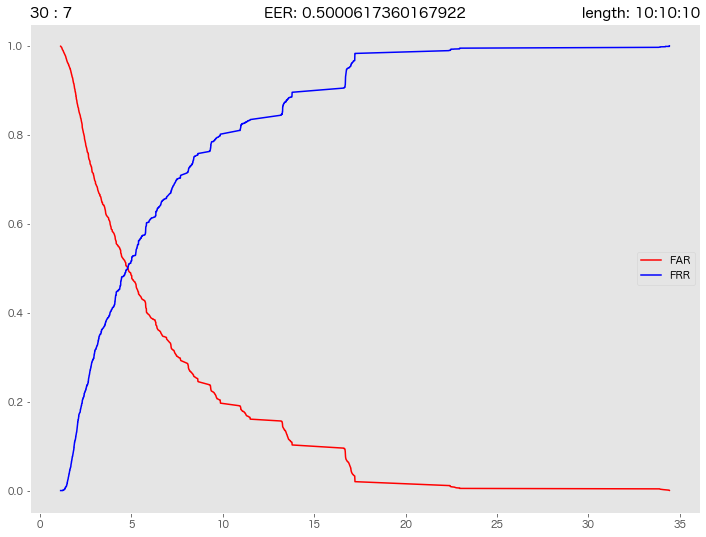

0.49882115190299764


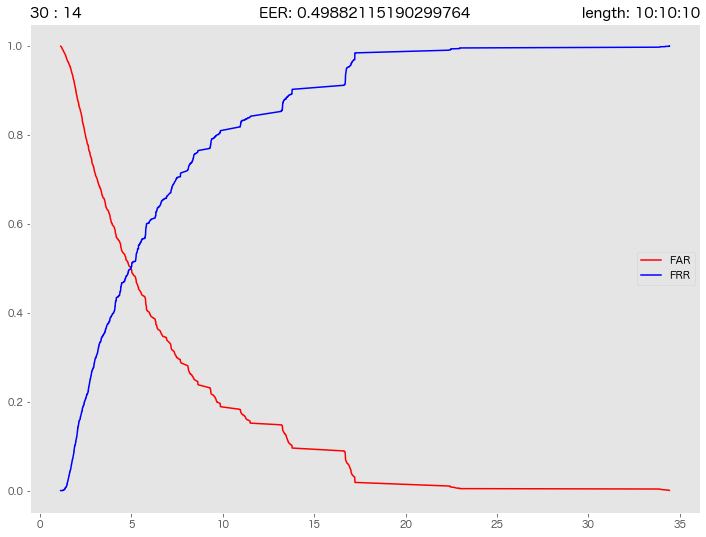

0.4972722593926917


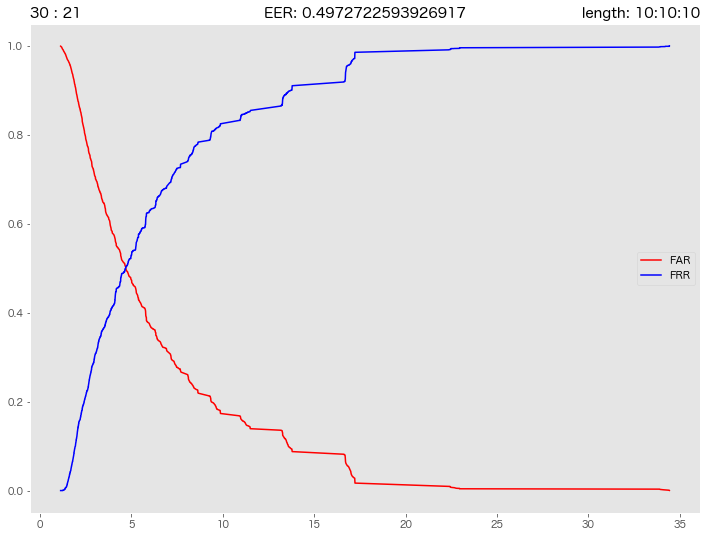

0.49995248503278533


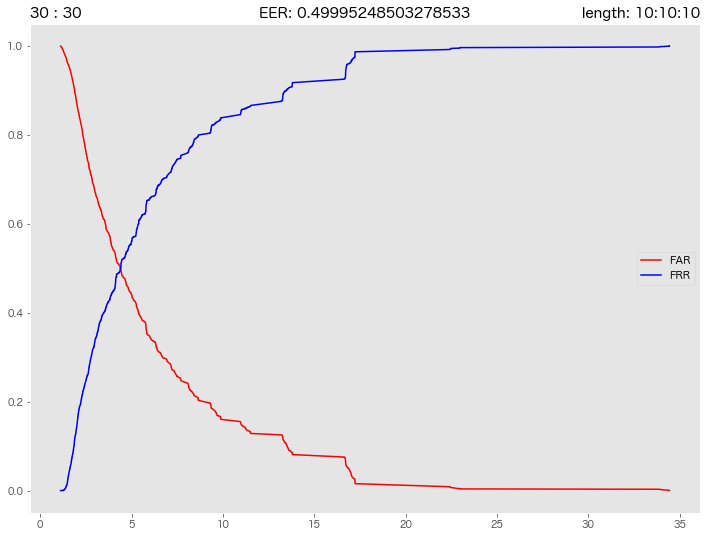

In [64]:
first_date_cand = pd.date_range("2022-01-01", "2022-02-01")
score_G = []
score_I = []
data = df
days = [7, 14, 21, 30]
clf = LocalOutlierFactor(n_neighbors=3)
bins = np.linspace(0, 100, 11)

for a in range(len(days)):
    diff_day_1 = days[a]
    for b in range(len(days)):
        diff_day_2 = days[b]
        for h in range(len(users)):
            user = users[h]
            for i in range(0, 101):
                first_date = first_date_cand[
                    np.random.randint(0, len(first_date_cand), 1)
                ]
                last_date = first_date + dt.timedelta(days=diff_day_1)
                imposters = users.copy()
                imposters = imposters[~(imposters == user)]
                imposter = np.random.choice(imposters)

                t_Q = pd.DataFrame(
                    data.loc[
                        (data["User"] == user)
                        & (data["state"] == "ON")
                        & (data["date"] > first_date[0] + dt.timedelta(seconds=1))
                        & (data["date"] < last_date[0])
                    ]["battery"].copy()
                )
                q1 = t_Q["battery"].quantile(0.25)
                q3 = t_Q["battery"].quantile(0.75)
                t_Q = t_Q.query("@q1 < battery < @q3")
                t_Q = np.array(t_Q)
                t_Q = t_Q.reshape(len(t_Q), 1)
                try:
                    pred = clf.fit_predict(t_Q)
                except:
                    break
                t_Q = t_Q[np.where(pred > 0)]
                t_Q = pd.DataFrame(t_Q, columns=["battery"])

                freq_1 = t_Q["battery"].value_counts(bins=bins, sort=False)
                t_Q = freq_1 / t_Q["battery"].count()

                t_T = pd.DataFrame(
                    data.loc[
                        (data["User"] == user)
                        & (data["state"] == "ON")
                        & (
                            data["date"]
                            > (first_date[0] - dt.timedelta(days=diff_day_2))
                        )
                        & (data["date"] < (first_date[0]))
                    ]["battery"].copy()
                )
                q1 = t_T["battery"].quantile(0.25)
                q3 = t_T["battery"].quantile(0.75)
                t_T = t_T.query("@q1 < battery < @q3")
                t_T = np.array(t_T)
                t_T = t_T.reshape(len(t_T), 1)
                try:
                    pred = clf.fit_predict(t_T)
                except:
                    break
                t_T = t_T[np.where(pred > 0)]
                t_T = pd.DataFrame(t_T, columns=["battery"])
                freq_1 = t_T["battery"].value_counts(bins=bins, sort=False)
                t_T = freq_2 / t_T["battery"].count()

                i_Q = pd.DataFrame(
                    data.loc[
                        (data["User"] == imposter)
                        & (data["state"] == "ON")
                        & (data["date"] > first_date[0] + dt.timedelta(seconds=1))
                        & (data["date"] < last_date[0])
                    ]["battery"].copy()
                )
                q1 = i_Q["battery"].quantile(0.25)
                q3 = i_Q["battery"].quantile(0.75)
                i_Q = i_Q.query("@q1 < battery < @q3")
                i_Q = np.array(i_Q)
                i_Q = i_Q.reshape(len(i_Q), 1)
                try:
                    pred = clf.fit_predict(i_Q)
                except:
                    break
                i_Q = i_Q[np.where(pred > 0)]
                i_Q = pd.DataFrame(i_Q, columns=["battery"])
                freq_1 = i_Q["battery"].value_counts(bins=bins, sort=False)
                i_Q = freq_1 / i_Q["battery"].count()

                score_G.append(distance.euclidean(t_T, t_Q))
                score_I.append(distance.euclidean(t_T, i_Q))

        grand_truth = np.concatenate((np.ones(len(score_G)), np.zeros(len(score_I))))
        score = np.concatenate((score_G, score_I))
        far, tpr, threshold = metrics.roc_curve(grand_truth, score)
        auc = metrics.auc(far, tpr)
        frr = 1.0 - tpr
        eer = far[np.where((far - frr) < 0)[0][-1]]
        print(eer)

        far_kai = pd.DataFrame(far[1:-1]).copy().set_index(threshold[1:-1])
        frr_kai = pd.DataFrame(frr[1:-1]).copy().set_index(threshold[1:-1])

        fig = plt.figure()
        plt.title(f"{diff_day_1} : {diff_day_2}", loc="left")
        plt.title(f"EER: {eer}", loc="center")
        plt.title(f"length: {len(t_T)}:{len(t_Q)}:{len(i_Q)}", loc="right")

        plt.plot(far_kai, color="r", label="FAR")
        plt.plot(frr_kai, color="b", label="FRR")
        plt.legend()
        plt.grid()
        plt.show()

        fig.savefig(f"../bs_2_results/{diff_day_1}_{diff_day_2}_freq_q_lof_on.png")